#Crowd Scene Analysis:
Crowd counter

             -- Vishakha Bhat

Download the Shanghai Dataset from the drive link: https://drive.google.com/drive/folders/1JE_f8oNuUCDvNckyIEQbIQq39oUpmUAS?usp=sharing
  as it is.

  Upload the Model.json, VGG_16.json, and the vgg16weights.h5 file. (Note all these files shall be in the Github repository for your kind information. )

  



Run the below code which sets the base for creating Density maps for Ground truths of images for both Part A and Part B of the Shanghai Dataset.

Note that the sum(Count of people) is also printed.


In [16]:
                                                                                
#'''dataset'''
import os
import random
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
#from image import *
import torchvision.transforms.functional as F

class listDataset(Dataset):
    def __init__(self, root, shape= None, shuffle= True, transform= None,  train= False, seen= 0, batch_size= 1, num_workers= 4):
        if train:
            root = root *4
        random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.transform = transform
        self.train = train
        self.shape = shape
        self.seen = seen
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        
    def __len__(self):
        return self.nSamples
    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)
        
        #img = 255.0 * F.to_tensor(img)
        
        #img[0,:,:]=img[0,:,:]-92.8207477031
        #img[1,:,:]=img[1,:,:]-95.2757037428
        #img[2,:,:]=img[2,:,:]-104.877445883


        
        
        if self.transform is not None:
            img = self.transform(img)
        return img,target

#'''image ka'''

import random
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import h5py
from PIL import ImageStat
import cv2

def load_data(img_path,train = True):
    gt_path = img_path.replace('.jpg','.h5').replace('images','ground_truth')
    img = Image.open(img_path).convert('RGB')
    gt_file = h5py.File(gt_path)
    target = np.asarray(gt_file['density'])
    if False:
        crop_size = (img.size[0]/2,img.size[1]/2)
        if random.randint(0,9)<= -1:
            
            
            dx = int(random.randint(0,1)*img.size[0]*1./2)
            dy = int(random.randint(0,1)*img.size[1]*1./2)
        else:
            dx = int(random.random()*img.size[0]*1./2)
            dy = int(random.random()*img.size[1]*1./2)
        
        
        
        img = img.crop((dx,dy,crop_size[0]+dx,crop_size[1]+dy))
        target = target[dy:crop_size[1]+dy,dx:crop_size[0]+dx]
        
        
        
        
        if random.random()>0.8:
            target = np.fliplr(target)
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
    
    
    
    
    target = cv2.resize(target,(target.shape[1]/8,target.shape[0]/8),interpolation = cv2.INTER_CUBIC)*64
    
    
    return img,target


#''' model'''


import torch.nn as nn
import torch
from torchvision import models
#from utils import save_net,load_net

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)




  

#'''utils'''

import h5py
import torch
import shutil

def save_net(fname, net):
    with h5py.File(fname, 'w') as h5f:
        for k, v in net.state_dict().items():
            h5f.create_dataset(k, data=v.cpu().numpy())
def load_net(fname, net):
    with h5py.File(fname, 'r') as h5f:
        for k, v in net.state_dict().items():        
            param = torch.from_numpy(np.asarray(h5f[k]))         
            v.copy_(param)
            
def save_checkpoint(state, is_best,task_id, filename='checkpoint.pth.tar'):
    torch.save(state, task_id+filename)
    if is_best:
        shutil.copyfile(task_id+filename, task_id+'model_best.pth.tar')

                                    
                                
# importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
#from image import *
#from model import CSRNet
import torch
from tqdm import tqdm
%matplotlib inline
import scipy.spatial


In [17]:
# function to create density maps for images
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [18]:
#setting the root to the Shanghai dataset you have downloaded
# change the root path as per your location of dataset
root = '/content/drive/My Drive/Shanghai'

In [19]:
part_A_train = os.path.join(root,'/content/drive/My Drive/Shanghai/PartAtrainimages')
part_A_test = os.path.join(root,'/content/drive/My Drive/Shanghai/PartAtestimages')
part_B_train = os.path.join(root,'/content/drive/My Drive/Shanghai/PartBtrainimages')
part_B_test = os.path.join(root,'/content/drive/My Drive/Shanghai/PartBtestimages')
path_sets = [part_A_train,part_A_test]

In [20]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [21]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k 

/content/drive/My Drive/Shanghai/PartAtrainimages/IMG_213.jpg
(749, 1000)
generate density...
done.
/content/drive/My Drive/Shanghai/PartAtrainimages/IMG_211.jpg
(334, 1024)
generate density...
done.
/content/drive/My Drive/Shanghai/PartAtrainimages/IMG_212.jpg
(688, 1024)
generate density...


KeyboardInterrupt: ignored

In [15]:
#for mouting your google drive: if you have the datasets in your drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We display the count and Density map for one of the images for example:

245.44603


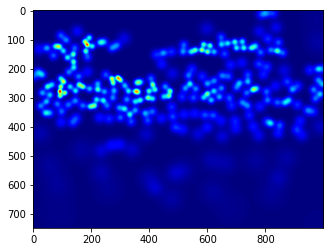

In [22]:
  for i in range(1):
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    plt.imshow(groundtruth,cmap=CM.jet)
    print(np.sum(groundtruth))


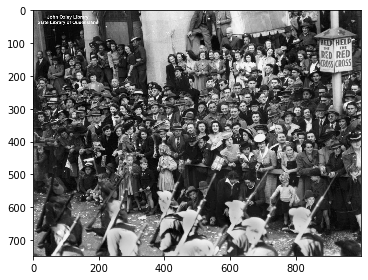

245.44603


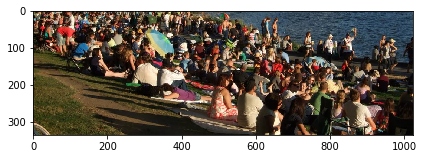

185.91193


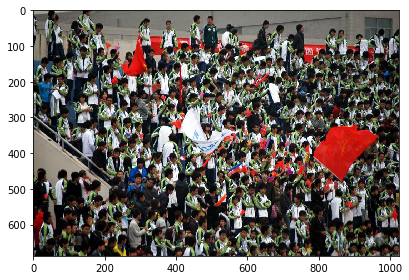

333.94135


KeyboardInterrupt: ignored

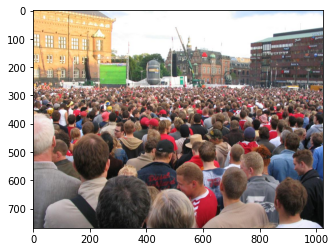

In [23]:
from matplotlib import pyplot as plt
from PIL import Image

import numpy as np
import tensorflow as tf
import cv2
import time
import glob
from progressbar import *
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import data, io
from matplotlib import pyplot as plt


for i in range(300):
  plt.imshow(Image.open(img_paths[i]))
  gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
  groundtruth = np.asarray(gt_file['density'])
  plt.imshow(groundtruth,cmap=CM.jet)
  tup=(np.sum(groundtruth))
  #print(np.sum(groundtruth))
  cv2.putText(img,'Count = '+str(tup),(10,400),cv2.FONT_HERSHEY_SIMPLEX, 1.25,(255,255,0),2,cv2.LINE_AA)
  io.imshow(img_paths[i])
  plt.show()
  print(np.sum(groundtruth))
  

The above outputs show the estimated numbers of people in the crowd

WE NEXT DO THE SAME PROCESS FOR PART B OF THE SHANGHAI DATASET

In [27]:
#for partB

path_sets = [part_B_train,part_B_test]
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)


In [28]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k       


/content/drive/My Drive/Shanghai/PartBtrainimages/IMG_213.jpg


AttributeError: ignored

34.069992


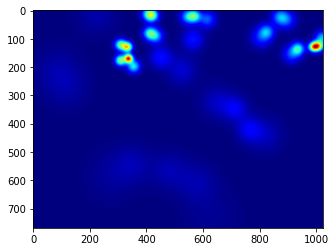

In [29]:
for i in range(1):
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    plt.imshow(groundtruth,cmap=CM.jet)
    print(np.sum(groundtruth))

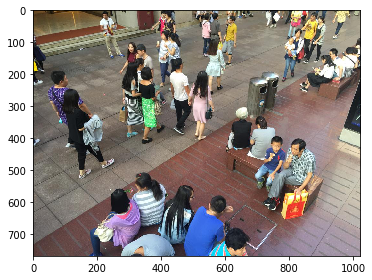

34.069992


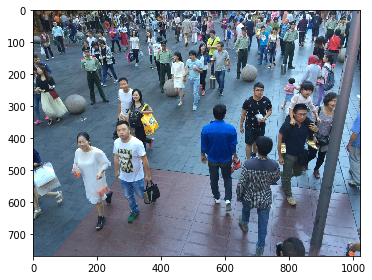

104.16675


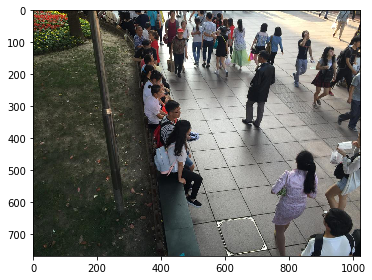

32.222454


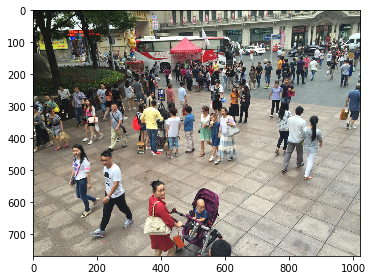

162.62282


KeyboardInterrupt: ignored

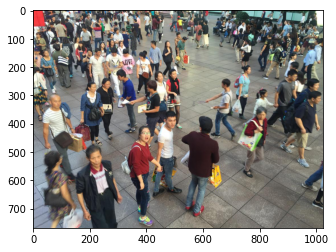

In [30]:
from matplotlib import pyplot as plt
from PIL import Image

import numpy as np
import tensorflow as tf
import cv2
import time
import glob
from progressbar import *
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import data, io
from matplotlib import pyplot as plt


for i in range(300):
  plt.imshow(Image.open(img_paths[i]))
  gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
  groundtruth = np.asarray(gt_file['density'])
  plt.imshow(groundtruth,cmap=CM.jet)
  tup=(np.sum(groundtruth))
  #print(np.sum(groundtruth))
  cv2.putText(img,'Count = '+str(tup),(10,400),cv2.FONT_HERSHEY_SIMPLEX, 1.25,(255,255,0),2,cv2.LINE_AA)
  io.imshow(img_paths[i])
  plt.show()
  print(np.sum(groundtruth))

NOW WE TRAIN THE MODEL USING THOSE GROUND TRUTH VALUES!

In [31]:
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array
from sklearn.metrics import mean_squared_error
from keras.initializers import RandomNormal
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from keras.models import Model,Sequential
from keras.layers import *
from keras import backend as K
from keras.models import model_from_json
from matplotlib import cm as CM
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import scipy.io as io
from PIL import Image
import PIL
import h5py
import os
import glob
import cv2
import random
import math
import sys

Using TensorFlow backend.


In [32]:
K.clear_session()
root = os.path.join(os.getcwd(),'/content/drive/My Drive/Shanghai')
print(root)

/content/drive/My Drive/Shanghai


In [33]:
part_A_train = os.path.join(root,'/content/drive/My Drive/Shanghai/PartAtrainimages')
part_A_test = os.path.join(root,'/content/drive/My Drive/Shanghai/PartAtestimages')
part_B_train = os.path.join(root,'/content/drive/My Drive/Shanghai/PartBtrainimages')
part_B_test = os.path.join(root,'/content/drive/My Drive/Shanghai/PartBtestimages')
temp = 'test_images'
path_sets = [part_A_train]

In [34]:
img_paths = []

for path in path_sets:
    
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        
        img_paths.append(str(img_path))
        
print("Total images : ",len(img_paths))

Total images :  300


In [35]:
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225

    #print(im.shape)
    #im = np.expand_dims(im,axis  = 0)
    return im

def get_input(path):
    path = path[0] 
    img = create_img(path)
    return(img)
    
    
    
def get_output(path):
    #import target
    #resize target
    
    gt_file = h5py.File(path,'r')
    
    target = np.asarray(gt_file['density'])
    
    img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    
    img = np.expand_dims(img,axis  = 3)
    
    #print(img.shape)
    
    return img
    
    
    
def preprocess_input(image,target):
    #crop image
    #crop target
    #resize target
    crop_size = (int(image.shape[0]/2),int(image.shape[1]/2))
    
    
    if random.randint(0,9)<= -1:            
            dx = int(random.randint(0,1)*image.shape[0]*1./2)
            dy = int(random.randint(0,1)*image.shape[1]*1./2)
    else:
            dx = int(random.random()*image.shape[0]*1./2)
            dy = int(random.random()*image.shape[1]*1./2)

    #print(crop_size , dx , dy)
    img = image[dx : crop_size[0]+dx , dy:crop_size[1]+dy]
    
    target_aug = target[dx:crop_size[0]+dx,dy:crop_size[1]+dy]
    #print(img.shape)

    return(img,target_aug)

In [36]:
#Image data generator 
def image_generator(files, batch_size = 64):
    
    while True:
        
        input_path = np.random.choice(a = files, size = batch_size)
        
        batch_input = []
        batch_output = [] 
          
        #for input_path in batch_paths:
        
        inputt = get_input(input_path )
        output = get_output(input_path[0].replace('.jpg','.h5').replace('images','ground_truth') )
            
       
        batch_input += [inputt]
        batch_output += [output]
    

        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        yield( batch_x, batch_y )

In [37]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    
    model_json = model.to_json()
    
    with open(str2, "w") as json_file:
        json_file.write(model_json)

In [42]:
import os
#part_B_train_with_val=os.listdir("/content/For json")

def init_weights_vgg(model):
    vgg =  VGG16(weights='imagenet', include_top=False)
    #part_B_train_with_val= ["/content/drive/My Drive/Shanghai/PartBtrainimages/IMG_1.jpg", "/content/drive/My Drive/Shanghai/PartBtrainimages/IMG_101.jpg","/content/drive/My Drive/Shanghai/PartBtrainimages/IMG_109.jpg","/content/drive/My Drive/Shanghai/PartBtrainimages/IMG_119.jpg" , "/content/drive/My Drive/Shanghai/PartBtrainimages/IMG_150.jpg"]
    #json_string=json.dumps(part_B_train_with_val)
    json_file = open( '/content/VGG_16.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("/content/vgg16weights.h5")
    
    vgg = loaded_model
    
    vgg_weights=[]                         
    for layer in vgg.layers:
        if('conv' in layer.name):
            vgg_weights.append(layer.get_weights())
    
    
    offset=0
    i=0
    while(i<10):
        if('conv' in model.layers[i+offset].name):
            model.layers[i+offset].set_weights(vgg_weights[i])
            i=i+1
            #print('h')
            
        else:
            offset=offset+1

    return (model)

In [43]:
def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function) 
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [44]:
# Neural network model : VGG + Conv
def CrowdNet():  
            #Variable Input Size
            rows = None
            cols = None
            
            #Batch Normalisation option
            
            batch_norm = 0
            kernel = (3, 3)
            init = RandomNormal(stddev=0.01)
            model = Sequential() 
            
            #custom VGG:
            
            if(batch_norm):
                model.add(Conv2D(64, kernel_size = kernel, input_shape = (rows,cols,3),activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                
            else:
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same',input_shape = (rows, cols, 3), kernel_initializer = init))
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                
                

                
            #Conv2D
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
        
            sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
            model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
            
            model = init_weights_vgg(model)
            
            return model

In [45]:
model = CrowdNet()

In [46]:
train_gen = image_generator(img_paths,1)

In [47]:
sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])

In [48]:
save_mod(model,"/content/vgg16weights.h5","/content/Model.json")

AT THIS POINT THE MODEL IS SAVED AS Mode.json. 
MAKING THE MODEL SHALL TAKE A LOT OF TIME. SO INSTEAD OF YOU WAITING FOR IT, I HAVE INCLUDED THE FILE.

In [49]:
import cv2
import h5py
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as c
from keras.models import model_from_json

In [50]:
def load_model():
    # Function to load and return neural network model 
    json_file = open('Model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("/content/vgg16weights.h5")
    return loaded_model

def create_img(path):
    #Function to load,normalize and return image 
    print(path)
    im = Image.open(path).convert('RGB')
    
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225


    im = np.expand_dims(im,axis  = 0)
    return im

In [51]:
def predict(path):
    #Function to load image,predict heat map, generate count and return (count , image , heat map)
    model = load_model()
    image = create_img(path)
    ans = model.predict(image)
    count = np.sum(ans)
    return count,image,ans

NOW WE PREDICT THE COUNT USING RANDOM PICTURES.

You can download these pictures from the drive and upload them :
https://drive.google.com/file/d/1vrkxu5ckYrcp-kZiyxXSYou6Gjl5CWdz/view?usp=sharing
and 
https://drive.google.com/file/d/1ej4kYi-aHgM84gMJotoyg0igS4DTBEdB/view?usp=sharing

In [53]:
ans,img,hmap = predict('/content/NAMI-Main-bg-1-1024x427.png')

/content/NAMI-Main-bg-1-1024x427.png


FileNotFoundError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5.9044056


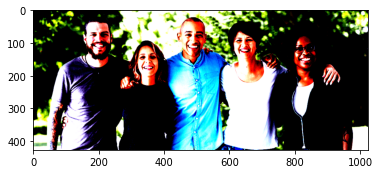

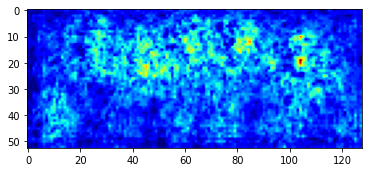

In [ ]:
print(ans)
#Print count, image, heat map
plt.imshow(img.reshape(img.shape[1],img.shape[2],img.shape[3]))
plt.show()
plt.imshow(hmap.reshape(hmap.shape[1],hmap.shape[2]) , cmap = c.jet )
plt.show()

/content/download (1).jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.5839765


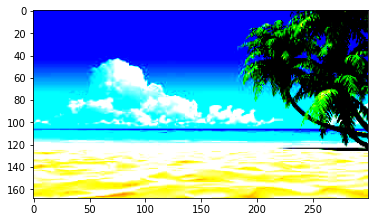

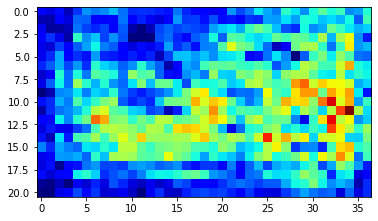

In [ ]:
ans,img,hmap = predict('/content/download (1).jpg')
print(ans)
#Print count, image, heat map
plt.imshow(img.reshape(img.shape[1],img.shape[2],img.shape[3]))
plt.show()
plt.imshow(hmap.reshape(hmap.shape[1],hmap.shape[2]) , cmap = c.jet )
plt.show()


THE RESULTS ARE PRETTY ACCURATE!
NOT 100% ACCURATE, BUT THEY ARE PRETTY FINE:)